# Teacher Forcing in RNNs

**Roberto Fierimonte** - 19/02/2018

---

In [1]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
tf.enable_eager_execution()

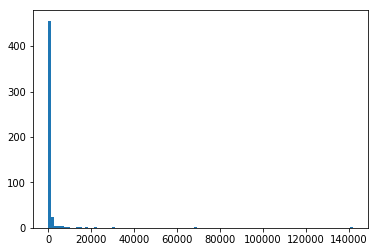

In [54]:
invg = tfd.InverseGamma(1., 120.)
samples = invg.sample((500))
plt.hist(samples.numpy(), bins=100);

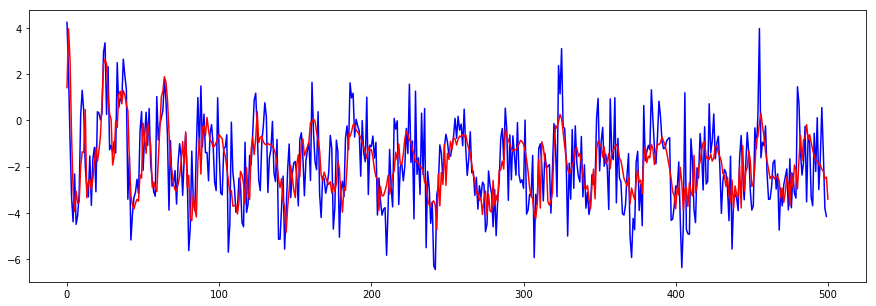

In [2]:
np.random.seed(5)
n_hidden = 50; seq_length = 500;
h = np.zeros((seq_length + 1, n_hidden)); h[0] = np.random.randn(1, n_hidden)
y = np.zeros((seq_length + 1, 1)); y[0] = np.random.randn(1)
sigma_c = 1.2
# sigma_b = .2

A = 0.05 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = 0.02 * np.random.randn(1, n_hidden)
b = np.random.rand(n_hidden, 1)
c = 0.2 * np.random.randn(n_hidden, 1)
bias_h = 0

for i in range(1, seq_length + 1):
    h[i] = np.tanh(np.dot(h[i-1], R) + np.dot(y[i-1], B))
    y[i] = 4 * np.tanh(np.dot(h[i], b)) + np.dot(h[i], c) * np.random.randn()

y_tilde = (y[1:] + sigma_c * np.random.randn(seq_length, 20)).T
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[0], 'b')
plt.plot(y, 'r')
ts = y_tilde[-1]

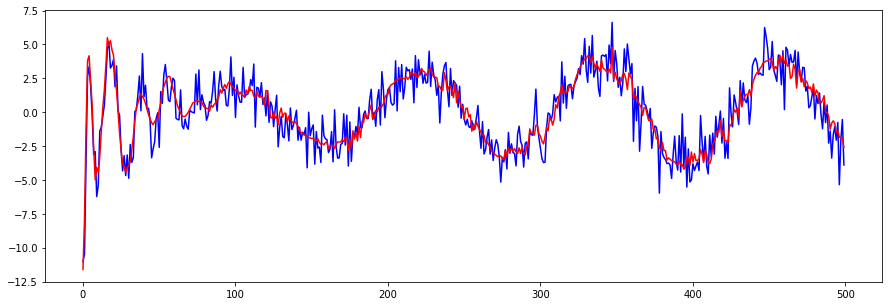

In [3]:
# np.random.seed(7)
# np.random.seed(2)
np.random.seed(1)
n_hidden = 50; seq_length = 500;
h = np.zeros((seq_length + 1, n_hidden)); h[0] = np.random.randn(1, n_hidden)
y = np.zeros((seq_length + 1, 1)); y[0] = np.random.randn(1)
sigma_c = 1.2
# sigma_b = .2

A = 0.8 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = 0.02 * np.random.randn(1, n_hidden)
b = np.random.randn(n_hidden, 1)
c = 0.5 * np.random.randn(n_hidden, 1)
bias_h = 0

for i in range(1, seq_length + 1):
    h[i] = 0.3 * np.tanh(np.dot(h[i-1], R) + np.dot(y[i-1], B)) + 0.7 * h[i-1]
    y[i] = 10 * np.tanh(np.dot(h[i], b)) + np.dot(h[i], c) * np.random.randn()

y_tilde = (y[1:] + sigma_c * np.random.randn(seq_length, 20)).T
#            (1.2 * np.maximum(0, 2 * np.tanh(2 * y[1:] - 4)) + 0.5) * np.random.randn(seq_length, 20)).T
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[0], 'b')
plt.plot(y[1:], 'r')
ts = y_tilde[-1]

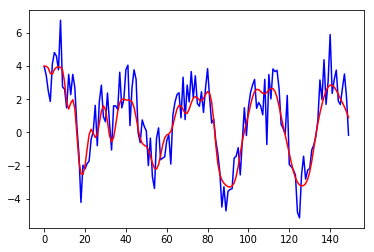

In [60]:
np.random.seed(0)
n_hidden = 50; seq_length = 300;
h = np.zeros((seq_length + 1, n_hidden)); h[0] = np.random.randn(1, n_hidden)
y = np.zeros((seq_length + 1, 1)); y[0] = np.random.randn(1)
sigma_c = 1.2
sigma_b = 0

A = 0.05 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = 0.01 * np.random.randn(1, n_hidden)
b = np.random.rand(n_hidden, 1)
bias_h = 0

for i in range(1, seq_length + 1):
    h[i] = np.tanh(np.dot(h[i-1], R) + np.dot(y[i-1], B))
    y[i] = 4 * np.tanh(np.dot(h[i], b)) + sigma_b * np.random.randn()

y_tilde = (y[1:] + sigma_c * np.random.randn(seq_length, 20)).T
plt.plot(y_tilde[0, :150], 'b')
plt.plot(y[1:151], 'r')
ts = y_tilde[-1]

In [4]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

# Baseline Model

In [55]:
class SimpleSamplingCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, cell, output_size, layer, reuse=None):
        super(SimpleSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._layer = layer

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size)
    
    def call(self, _, state_and_sample):
        (state, sample) = state_and_sample
        out, state = self._cell(sample, state)
        sample = self._layer(out)
        return sample, (state, sample)
    
class BaselineModel(object):
    """
    """
    def __init__(self, cell_type='GRU', n_hidden=100):
        self._n_hidden = n_hidden
        self._cell_type = cell_type
        if cell_type == 'Linear':
            self._cell = LinearCell(1, self._n_hidden)
            self._sampling_cell = self._cell
        else:
            self._layer = tf.layers.Dense(1)
            if cell_type == 'GRU':
                self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
            elif cell_type == 'LSTM':
                self._cell = tf.contrib.rnn.LSTMBlockCell(self._n_hidden)
            elif cell_type == 'RNN':
                self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)
            self._sampling_cell = SimpleSamplingCell(self._cell, 1, self._layer)

    def compute_forward(self, data):
        (out, hidden) = tf.nn.dynamic_rnn(self._cell, inputs=data, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out, hidden    
    
    def pred_forward(self, data, last_training_point, last_hidden):
        inputs = tf.concat([last_training_point[:, None], data], 1)        
        (out, _) = tf.nn.dynamic_rnn(self._cell, inputs=inputs, initial_state=last_hidden, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out
    
    def pred_forward_autoregressive(self, last_training_point, last_hidden, future=500):
        sample = last_training_point
        hidden = last_hidden
        samples = []
        
        for _ in range(future):
            (sample, hidden) = self._cell(sample, hidden)
            if self._cell_type != 'Linear':
                sample = self._layer(sample)
            samples.append(sample)
            
        return tf.transpose(tf.stack(samples, 0), [1,0,2])

In [72]:
tf.reset_default_graph()

seq_length = 150; cell_type = 'GRU'; n_hidden = 50; batch_size = 10
x_ = tf.placeholder(tf.float32, [None, None, 1])
x_test = tf.placeholder(tf.float32, [None, None, 1])

with tf.variable_scope(cell_type + '_' + str(n_hidden), reuse=tf.AUTO_REUSE) as scope:
    model = BaselineModel(cell_type, n_hidden)
    res, hidden = model.compute_forward(x_[:, :-1])
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(res[..., 0] - x_[:, 1:, 0]), 1))/2
    optimise = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    pred_tf = model.pred_forward(x_test, x_[:, -1], hidden)
    pred_ar_tf = model.pred_forward_autoregressive(x_[:, -1], hidden, future=100)

config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.InteractiveSession(config=config) 
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
errors_baseline = []; preds_baseline = []; preds_baseline_ar = []; errors_test_baseline = []

timestamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d_%H:%M")

for i in range(10001):
    batch = y_tilde[:batch_size, :seq_length]
#     batch = ts[None, :seq_length+1]
#     batch = np.stack([ts[i:i+seq_length] for i in np.random.randint(0, 150-seq_length, 10)])    
    error = sess.run(loss, {x_: batch[..., None]})
    sess.run(optimise, {x_: batch[..., None]})
    errors_baseline.append(error)
    
    if i % 1000 == 0:
        test_batch = ts[seq_length:]
        test_error = sess.run(loss, {x_: test_batch[None, :, None]})
        errors_test_baseline.append(test_error)
        print('Iteration:', i, 'Training Error:', error, 'Test Error:', test_error)
        pred = sess.run(pred_tf, {x_: ts[None, :seq_length, None], 
                                  x_test: ts[None, seq_length:seq_length+50, None]})
        pred_ar = sess.run(pred_ar_tf, {x_: ts[None, :seq_length, None]})
        preds_baseline.append(pred); preds_baseline_ar.append(pred_ar)
        
# save_path = saver.save(sess, "/mnt/workspace/baseline_{}_length_{}_iter_{}.ckpt".format(timestamp, seq_length, i))

Iteration: 0 Training Error: 410.18604 Test Error: 459.34128
Iteration: 1000 Training Error: 105.72719 Test Error: 1449.8934
Iteration: 2000 Training Error: 88.82677 Test Error: 1014.6174
Iteration: 3000 Training Error: 77.45013 Test Error: 839.3967
Iteration: 4000 Training Error: 68.93963 Test Error: 1018.0985
Iteration: 5000 Training Error: 59.814056 Test Error: 1420.41
Iteration: 6000 Training Error: 52.973305 Test Error: 1773.5236
Iteration: 7000 Training Error: 48.32018 Test Error: 1886.4099
Iteration: 8000 Training Error: 42.18728 Test Error: 2372.895
Iteration: 9000 Training Error: 58.81948 Test Error: 2459.94
Iteration: 10000 Training Error: 37.023197 Test Error: 2398.3005


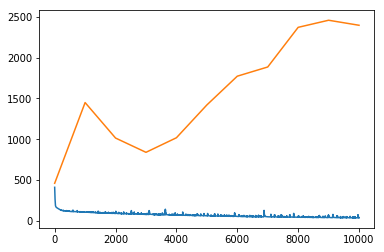

In [73]:
plt.plot(errors_baseline)
plt.plot(range(0, 10001, 1000), errors_test_baseline)

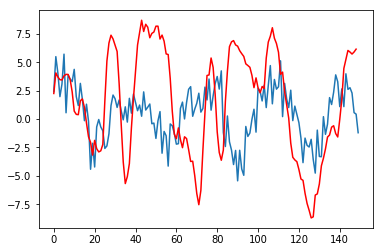

In [74]:
fit = sess.run(res, {x_: ts[None, :150, None]})
plt.plot(ts[None, :150].T)
plt.plot(fit[..., 0].T, 'r')

In [76]:
pred.shape

(1, 51, 1)

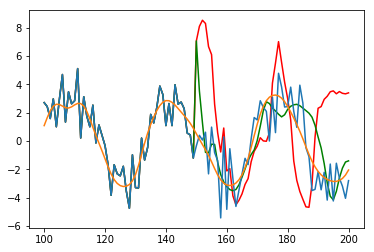

In [89]:
plt.plot(range(100, 201), np.concatenate([ts[None, 100:150, None], pred], 1)[0], 'r')
plt.plot(range(100, 201), np.concatenate([ts[None, 100:150, None], pred_ar[:, :51]], 1)[0], 'g-')
plt.plot(range(100, 201), ts[None, 100:201].T)
plt.plot(range(100, 201), y[101:202])

# Our Model

In [5]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, std=None, reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._std = std[None, None] if std is not None else None
        self._layer_h = tf.layers.Dense(20, tf.nn.relu)
        self._layer_m = tf.layers.Dense(event_size)
        self._layer_s = tf.layers.Dense(event_size, tf.nn.softplus)

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        _, state = self._cell(inputs, state)
        hidden = self._layer_h(state)
        mean = self._layer_m(hidden)
        if self._std is not None:
            batch_size = state.shape[0]
            std = tf.tile(self._std, [batch_size, 1])
        else:
            std = self._layer_s(hidden)
        return (mean, std), state
    
    def call_no_input(self, state):
        hidden = self._layer_h(state)
        mean = self._layer_m(hidden)
        if self._std is not None:
            batch_size = state.shape[0]
            std = tf.tile(self._std, [batch_size, 1])
        else:
            std = self._layer_s(hidden)
        return (mean, std), state
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, n_samples=1, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._n_samples = n_samples

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std), (state, sample)
    
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=100, n_samples=200, seq_length=1000, batch_size=1):
        self._data = data
        self._n_hidden = n_hidden
        self._batch_size = batch_size
        self._n_samples = n_samples
        self._seq_length = seq_length
        self._cell = tf.nn.rnn_cell.BasicRNNCell(self._n_hidden)
        self._layer = tf.layers.Dense(1)
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self._gen_stddev = tf.get_variable(name='generative_std', shape=(), trainable=False,
                                           initializer=tf.constant_initializer(1.2))
        self.make_posterior
        self.compute_elbo_david
        self.E_step
        self.M_step
        
#         self.make_forward_posterior
#         self.make_forward_parameters
#         self.compute_forward_message
#         self.compute_elbo_forward
#         self.forward_E_step
#         self.forward_M_step
    
    @define_scope
    def make_generative(self):
        stddevs = tf.layers.dense(tf.layers.dense(self._code, 20, tf.nn.tanh), 1, tf.nn.softplus)
        return stddevs
        
    @define_scope
    def make_posterior_z(self):
        self._post_cell_z = tf.nn.rnn_cell.BasicRNNCell(2 * self._n_hidden)
        _, h = tf.nn.dynamic_rnn(self._post_cell_z, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._n_hidden)
        stds = tf.layers.dense(h, self._n_hidden, tf.nn.softplus)
        return tfd.MultivariateNormalDiag(means, scale_diag=stds)
    
    @define_scope
    def make_posterior(self):
        self._post_cell_f = tf.nn.rnn_cell.BasicRNNCell(5)
        self._post_cell_b = tf.nn.rnn_cell.BasicRNNCell(5)
        (out_f, out_b), _ = tf.nn.bidirectional_dynamic_rnn(self._post_cell_f, self._post_cell_b, inputs=self._data, 
                                                            dtype=tf.float32)
        
        hidden = tf.concat([out_f, out_b], 2)
        hidden = tf.layers.dense(hidden, 10, tf.nn.tanh)
        means = tf.layers.dense(hidden, 1)
        means = tf.identity(means, name='post_means')
        stddevs = tf.layers.dense(hidden, 1, tf.nn.softplus)
        return tfd.MultivariateNormalDiag(means[..., 0], scale_diag=stddevs[..., 0])
        
    @define_scope
    def make_transitional(self):
        hidden = self._code_z
        self._gauss_cell = GaussianCell(self._cell, 1)
        (mean1, std1), _ = self._gauss_cell.call_no_input(hidden)
        
        inputs = self._code[:, :-1]
        (means, stddevs), _ = tf.nn.dynamic_rnn(self._gauss_cell, inputs=inputs, initial_state=hidden)
        return tf.concat([mean1, means[..., 0]], 1), tf.concat([std1, stddevs[..., 0]], 1)
    
    @define_scope
    def compute_elbo_david(self):      
        posterior = self.make_posterior
        code = posterior.sample((self._n_samples))
        self._code = tf.reshape(code, [-1, self._seq_length, 1])
        
        posterior_z = self.make_posterior_z
        code_z = posterior_z.sample((self._n_samples))
        self._code_z = tf.reshape(code_z, [-1, self._n_hidden])
        
#         entropy_y = self._batch_size * self._seq_length * tf.log(tf.square(self._post_stddev))
        entropy_y = tf.reduce_sum(tf.linalg.logdet(posterior.covariance()))
        entropy_z = tf.reduce_sum(tf.linalg.logdet(posterior_z.covariance()))
        entropy = entropy_y + entropy_z
        
        (means, stddevs) = self.make_transitional
        means = tf.reshape(means, [self._n_samples, self._batch_size, self._seq_length])
        stddevs = tf.reshape(stddevs, [self._n_samples, self._batch_size, self._seq_length])
        
        exponent_trans = tf.square(code - means)/tf.square(stddevs)
        norm_trans = tf.reduce_sum(tf.reduce_mean(tf.log(tf.square(stddevs)), 0))
#         norm_trans = self._batch_size * self._seq_length * tf.log(tf.square(self.trans_std))
        
        exponent_z = tf.square(posterior_z.mean())
        norm_z = self._batch_size * tf.linalg.logdet(tf.eye(self._n_hidden))
        kl_z = tf.reduce_sum(exponent_z) + norm_z
                                                     
        kl = - entropy + tf.reduce_sum(tf.reduce_mean(exponent_trans, 0)) + norm_trans + kl_z
        
#         gen_stddevs = self.make_generative
#         gen_stddevs = tf.reshape(gen_stddevs, [self._n_samples, self._batch_size, self._seq_length])
        exponent_gen = tf.square(code - self._data[None, ..., 0])/tf.square(self._gen_stddev)
        norm_gen = self._batch_size * self._seq_length * tf.log(tf.square(self._gen_stddev))
#         norm_gen = tf.reduce_sum(tf.reduce_mean(tf.log(tf.square(gen_stddevs)), 0))
        
        reconstruction = - tf.reduce_sum(tf.reduce_mean(exponent_gen, 0)) - norm_gen
        
        return reconstruction - kl, kl, reconstruction, entropy
    
    @define_scope
    def E_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo_david[0], var_list=post_var)
    
    @define_scope
    def M_step(self):
        non_post_var = [v for v in tf.trainable_variables() if not v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo_david[0], var_list=non_post_var)
    
#     @define_scope
#     def trans_std(self):
#         return self._trans_std
    
    @define_scope
    def gen_std(self):
        return self._gen_stddev    
    
#     @define_scope
#     def make_forward_posterior(self):
#         y_mu = tf.get_variable(shape=(), name='forward_y_mean', initializer=tf.constant_initializer(0))
#         y_sigma = tf.nn.softplus(tf.get_variable(shape=(), initializer=tf.constant_initializer(2), 
#                                                  name='forward_y_std'))
#         y_dist = tfd.Normal(y_mu, y_sigma)
#         return y_dist
    
#     @define_scope
#     def make_forward_parameters(self):
#         return tf.get_variable(shape=(50,), name='best_forward_sequence', initializer=tf.constant_initializer(0))
    
#     @define_scope
#     def compute_forward_message(self):
#         h0 = tf.zeros((self._n_samples, self._n_hidden))
#         y0 = tf.zeros((self._n_samples, 1))
#         code = tf.reshape(self._code, [self._n_samples, self._batch_size, self._seq_length])
#         _, h = self._cell(y0, h0)
#         for t in range(self._seq_length-1):
#             _, h = self._cell(code[:, 0, t, None], h)
#             h = tf.tile(tf.reduce_mean(h, 0, keepdims=True), [self._n_samples, 1])
        
#         dist_y = tfd.Normal(self.make_posterior.mean()[0, -1], self._post_stddev)
#         return dist_y, h
    
#     @define_scope
#     def forward_E_step(self):
#         post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_forward_posterior')]
#         return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)
    
#     @define_scope
#     def forward_M_step(self):
#         post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_forward_parameters')]
#         return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)
    
#     @define_scope
#     def make_rnn_forward(self):
#         _, hT = self.compute_forward_message
#         hT = tf.tile(tf.reduce_mean(hT, 0, keepdims=True), [2000, 1])
#         fake_inputs = tf.zeros((2000, 50, 1))
#         post_samples = self.make_forward_posterior.sample((2000))
#         (means, _), _ = tf.nn.dynamic_rnn(self._sampling_cell, inputs=fake_inputs, 
#                                           initial_state=(hT, post_samples[..., None]))
#         return means
    
#     @define_scope
#     def compute_elbo_forward(self):
#         self._forw_cell = CellWithSigma(self._cell, 1, self.trans_std, self._layer)
#         self._sampling_cell = SamplingCell(self._forw_cell, 1, self._n_samples)
        
#         post = self.make_forward_posterior
#         post_samples = post.sample((2000))
#         entropy = tf.log(tf.square(post.scale))
        
#         dist_y, _ = self.compute_forward_message
#         means = self.make_rnn_forward
        
#         pred = self.make_forward_parameters
#         reconstruction_exp = tf.square(pred[None, :] - means[..., 0])/tf.square(self.trans_std)
#         reconstruction_norm = 50 * tf.log(tf.square(self.trans_std))
#         reconstruction = - tf.reduce_mean(tf.reduce_sum(reconstruction_exp, -1)) - reconstruction_norm
        
#         cross = tf.square(dist_y.mean() - post_samples)/tf.square(dist_y.scale)
#         kl = - entropy + tf.reduce_mean(cross) + tf.log(tf.square(dist_y.scale))
        
#         return reconstruction - kl, kl, reconstruction, entropy

In [9]:
tf.reset_default_graph()

seq_length = 300; n_samples = 200; batch_size = 20;
# data = y_tilde[:batch_size, :seq_length]
data = []; indexes = []
for i in range(batch_size):
    t = np.random.randint(200); indexes.append(t)
    data.append(y_tilde[i, t:t+seq_length])
data = np.stack(data, 0)
# data = np.tile(y_tilde[:batch_size, :seq_length], (n_samples, 1))
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

gen_model = RobustARGenerator(x_, n_hidden=10, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
# tf.train.Saver().restore(sess, "/Users/robertofiermonte/Repository/model_{}_forward.ckpt".format(batch_size))

elbos = []; kls = []; llks = []; test_elbos = []; preds = []; preds_greedy = []
means = []; stds = []; gen_stddevs = []; post_stddevs = []; post_samples = []; post_means = []
    
for i in range(10001):
    batch = data
#     batch = ts[:seq_length][None, ...]
    elbo, kl, llk, entropy = sess.run(gen_model.compute_elbo_david, {x_: batch[..., None]})
    elbos.append(elbo); kls.append(kl); llks.append(llk)
    means_op = tf.get_default_graph().get_tensor_by_name('make_posterior/post_means:0')
    post_means.append(sess.run(means_op, {x_: batch[..., None]})[0])
#     post_stddevs.append(sess.run(gen_model._post_stddev))
    m = sess.run(gen_model.make_transitional, {x_: batch[..., None]})
#     s = sess.run(gen_model.trans_std, {x_: batch[..., None]})
    means.append(m); 
#     stds.append(s); 
#     gen_stddevs.append(sess.run(gen_model.gen_std, {x_: batch[..., None]}))
    latents = sess.run(gen_model._code, {x_: batch[..., None]})
    post_samples.append(latents)
    
    if i % 100 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'Reconstruction:', llk, 'Entropy:', entropy)
    
    sess.run(gen_model.E_step, {x_: batch[..., None]})
    sess.run(gen_model.M_step, {x_: batch[..., None]})

# tf.train.Saver().save(sess, '/Users/robertofiermonte/Repository/model_{}_forward.ckpt'.format(batch_size))

# for i in range(15001):   
#     elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: batch[..., None]})
#     sess.run(gen_model.forward_E_step, {x_: batch[..., None]})
#     sess.run(gen_model.forward_M_step, {x_: batch[..., None]})
    
#     if i % 1000 == 0:
#         print('Iteration:', i, 'ELBO Forward:', elbo_forward)

Iteration: 0 ELBO: -45542.566 KL: 24898.053 Reconstruction: -20644.514 Entropy: -4846.709
Iteration: 100 ELBO: -20151.46 KL: 9593.31 Reconstruction: -10558.15 Entropy: -6360.3887
Iteration: 200 ELBO: -18408.86 KL: 9068.002 Reconstruction: -9340.857 Entropy: -5602.795
Iteration: 300 ELBO: -17663.168 KL: 9130.644 Reconstruction: -8532.525 Entropy: -5005.268
Iteration: 400 ELBO: -17038.367 KL: 9099.745 Reconstruction: -7938.6216 Entropy: -4156.912
Iteration: 500 ELBO: -16651.203 KL: 9009.083 Reconstruction: -7642.1206 Entropy: -3693.9883
Iteration: 600 ELBO: -16415.303 KL: 8911.024 Reconstruction: -7504.2783 Entropy: -3491.5964
Iteration: 700 ELBO: -16173.193 KL: 8724.227 Reconstruction: -7448.9673 Entropy: -3460.3975
Iteration: 800 ELBO: -15985.22 KL: 8599.972 Reconstruction: -7385.248 Entropy: -3398.9504
Iteration: 900 ELBO: -15903.576 KL: 8578.182 Reconstruction: -7325.395 Entropy: -3504.7168
Iteration: 1000 ELBO: -15771.797 KL: 8473.258 Reconstruction: -7298.5396 Entropy: -3551.37
Ite

KeyboardInterrupt: 

In [ ]:
for i in range(10001):
    elbo_forward, kl_forw, rec_forw, entr_forw = sess.run(gen_model.compute_elbo_forward, {x_: batch[..., None]})
    
    if i % 100 == 0:
        print('Iteration:', i, 'ELBO Forward:', elbo_forward, 'KL:', kl_forw, 
              'Reconstruction:', rec_forw, 'Entropy:', entr_forw)
        
    sess.run(gen_model.forward_E_step, {x_: batch[..., None]})
    sess.run(gen_model.forward_M_step, {x_: batch[..., None]})

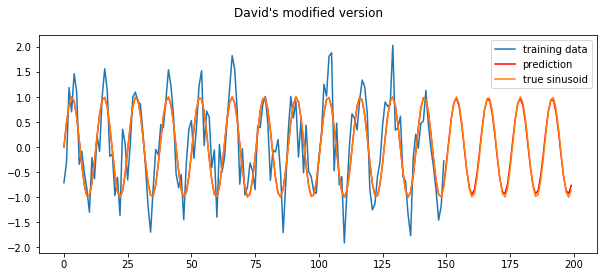

In [281]:
# plt.plot(sess.run(gen_model.make_rnn_forward, {x_: batch[..., None]})[4])
code = sess.run(gen_model.make_forward_parameters, {x_: batch[..., None]})
fig, axs = plt.subplots(1,1,figsize=(10, 4))
plt.plot(y_tilde[0, :seq_length], label='training data')
plt.plot(np.concatenate([y[:seq_length, None], code[:, None]], 0), 'r', label='prediction')
plt.plot(y[:seq_length+50, None], label='true sinusoid')
plt.legend()
plt.suptitle("David's modified version");

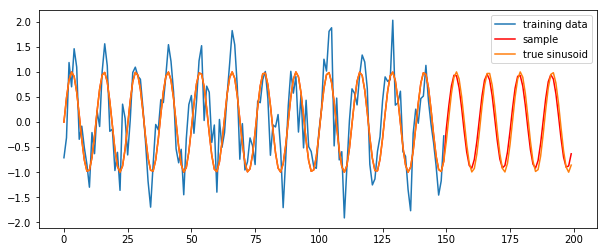

In [267]:
# plt.plot(sess.run(gen_model.make_rnn_forward, {x_: batch[..., None]})[4])
code = sess.run(gen_model.make_forward_parameters, {x_: batch[..., None]})
fig, axs = plt.subplots(1,1,figsize=(10, 4))
plt.plot(y_tilde[0, :seq_length], label='training data')
plt.plot(np.concatenate([y[:seq_length, None], code[:, None]], 0), 'r', label='sample')
plt.plot(y[:seq_length+50, None], label='true sinusoid')
plt.legend();

In [118]:
hT = sess.run(gen_model.compute_forward_message[1], {x_: batch[..., None]})

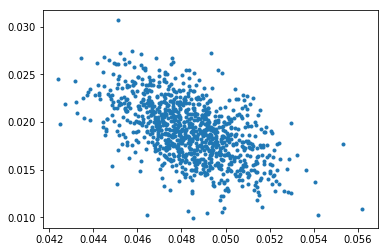

In [119]:
plt.plot(hT[:, 0], hT[:, 1], '.')

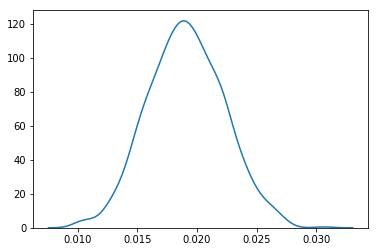

In [122]:
import seaborn as sns
sns.kdeplot(hT[:, 1])

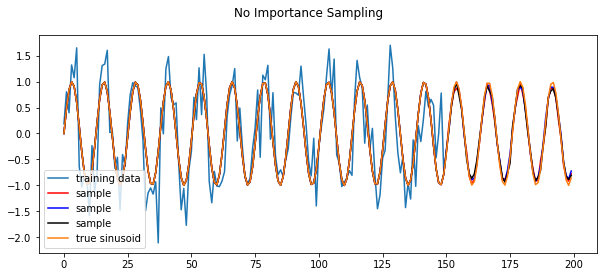

In [475]:
code = sess.run(gen_model._forward_code, {x_: batch[..., None]})
fig, axs = plt.subplots(1,1,figsize=(10, 4))
plt.plot(y_tilde[0, :seq_length], label='training data')
plt.plot(np.concatenate([y[:seq_length, None], code[1, 1:]], 0), 'r', label='sample')
plt.plot(np.concatenate([y[:seq_length, None], code[0, 1:]], 0), 'b', label='sample')
plt.plot(np.concatenate([y[:seq_length, None], code[2, 1:]], 0), 'k', label='sample')
plt.plot(y[:seq_length+50, None], label='true sinusoid')
plt.legend();
plt.suptitle('No Importance Sampling');

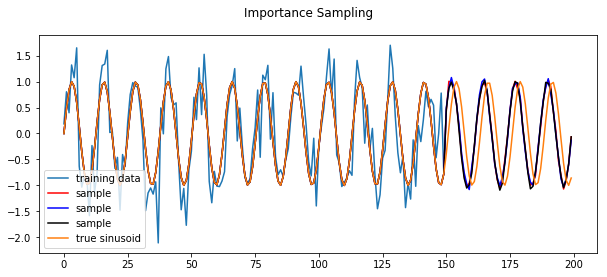

In [474]:
# code = sess.run(gen_model._forward_code, {x_: batch[..., None]})
fig, axs = plt.subplots(1,1,figsize=(10, 4))
plt.plot(y_tilde[0, :seq_length], label='training data')
plt.plot(np.concatenate([y[:seq_length, None], code[1, 1:]], 0), 'r', label='sample')
plt.plot(np.concatenate([y[:seq_length, None], code[0, 1:]], 0), 'b', label='sample')
plt.plot(np.concatenate([y[:seq_length, None], code[2, 1:]], 0), 'k', label='sample')
plt.plot(y[:seq_length+50, None], label='true sinusoid')
plt.legend();
plt.suptitle('Importance Sampling');

In [ ]:
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

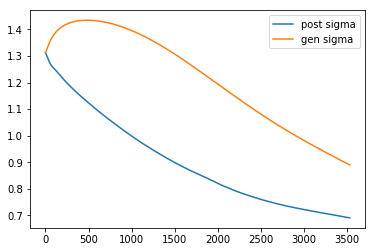

In [781]:
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
# plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

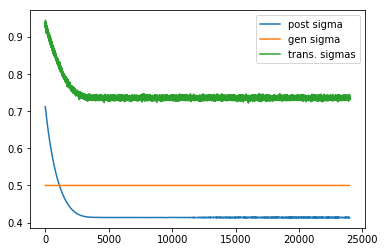

In [344]:
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

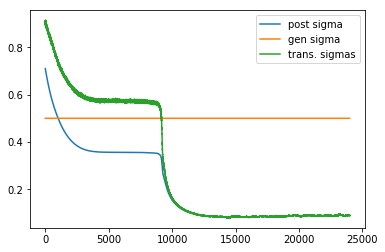

In [32]:
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

In [ ]:
plt.plot(ts[:70], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[t:t+seq_length], label='true sinusoid')
plt.legend();

In [271]:
np.reshape(means[-1], [n_samples, batch_size, seq_length])

(200, 10, 150)

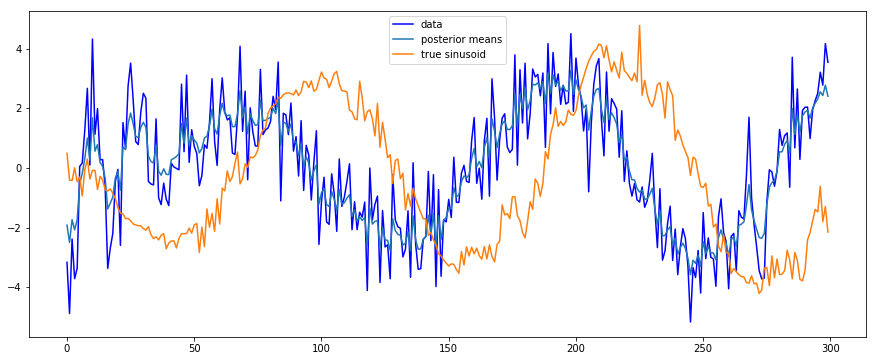

In [8]:
plt.subplots(1,1,figsize=(15,6))
plt.plot(batch[0, :seq_length], 'b', label='data')
# plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
# plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]})[0, :seq_length], label='posterior means')
plt.plot(y[1+:1+t+seq_length], label='true sinusoid')
plt.legend();

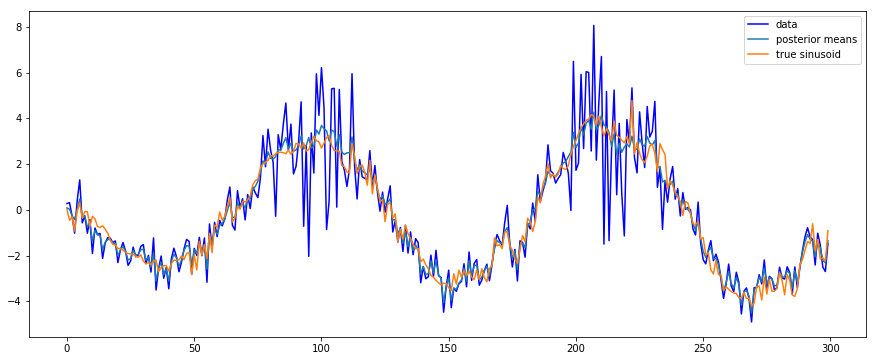

In [13]:
plt.subplots(1,1,figsize=(15,6))
plt.plot(batch[-1, :seq_length], 'b', label='data')
# plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
# plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]})[-1, :seq_length], label='posterior means')
plt.plot(y[1+t:1+t+seq_length], label='true sinusoid')
plt.legend();

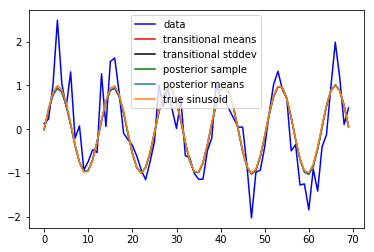

In [13]:
plt.plot(ts[:70], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:70], label='true sinusoid')
plt.legend();

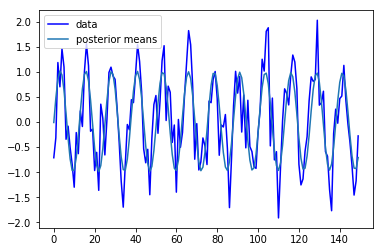

In [262]:
plt.plot(ts[:seq_length], 'b', label='data')
# plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
# plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
# plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

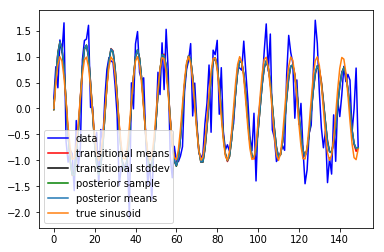

In [478]:
plt.plot(ts[:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

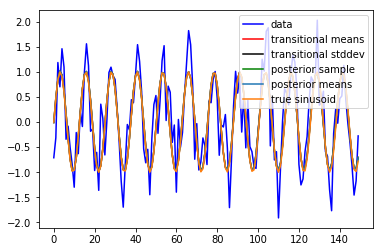

In [141]:
plt.plot(ts[:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

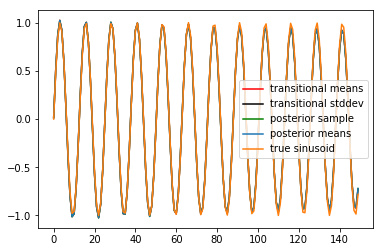

In [247]:
# plt.plot(ts[:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

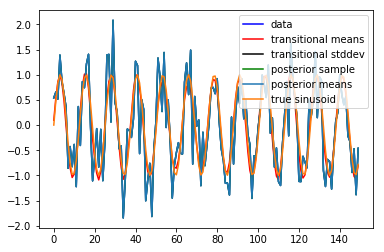

In [29]:
plt.plot(ts[:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

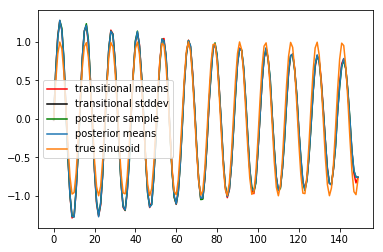

In [238]:
# plt.plot(ts[:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:seq_length], label='true sinusoid')
plt.legend();

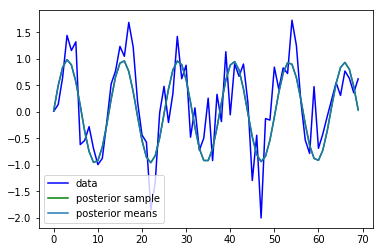

In [27]:
plt.plot(ts[:70], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:70], label='true sinusoid')
plt.legend();

In [10]:
from scipy.stats.distributions import invgamma, invgamma_gen

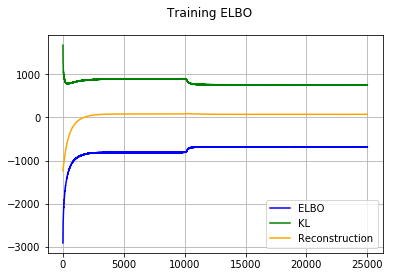

In [33]:
plt.plot(elbos, 'b', label='ELBO')
plt.plot(kls, 'g', label='KL')
plt.plot(llks, 'orange', label='Reconstruction')
plt.suptitle('Training ELBO')
plt.grid("on")
plt.legend()
plt.show()

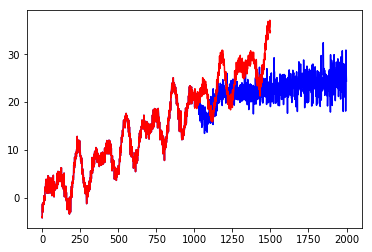

In [0]:
pred = sess.run(model.predict_forward, {x_: ts[:seq_length, None].T})
for i in range(1):
    plt.plot(np.concatenate([ts[:seq_length], pred[i]]), 'b')
plt.plot(np.concatenate([ts[:seq_length], ts[seq_length:seq_length+500]]), 'r')

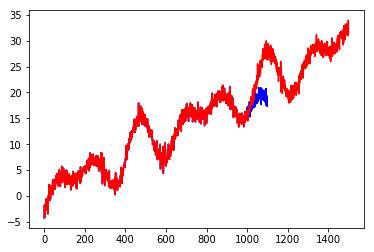

In [0]:
pred = sess.run(model.predict_forward, {x_: ts[:seq_length, None].T})
for i in range(1):
    plt.plot(np.concatenate([ts[:seq_length], pred[i][:500]]), 'b')
plt.plot(np.concatenate([ts[:seq_length], ts[seq_length:seq_length+500]]), 'r')

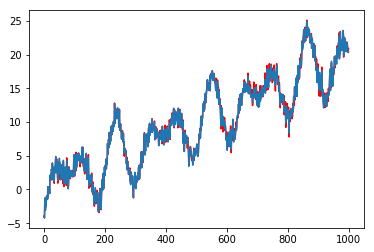

In [0]:
m, s = sess.run(model.make_transitional, {x_: ts[:seq_length, None].T})
plt.plot(ts[:seq_length], 'r')
plt.plot(m[0, :, 0])

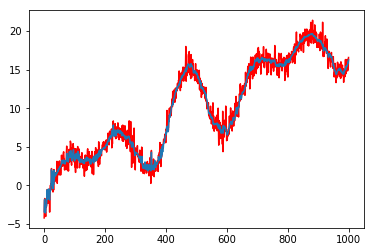

In [0]:
m, s = sess.run(model.make_transitional, {x_: ts[:seq_length, None].T})
plt.plot(ts[:seq_length], 'r')
plt.plot(m[0, :, 0])

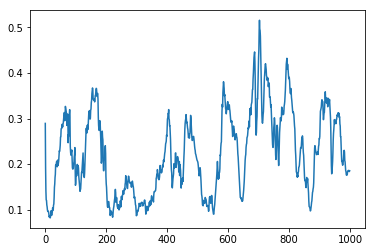

In [0]:
plt.plot(s[0, :, 0])

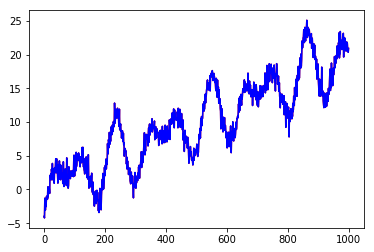

In [0]:
plt.plot(ts[:seq_length], 'r', test_latents[0, :, 0], 'b')

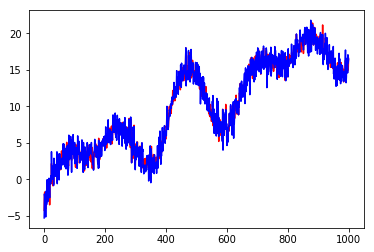

In [0]:
plt.plot(ts[:seq_length], 'r', test_latents[0, :, 0], 'b')